In [1]:
# %matplotlib inline


# 1) Wipe out your namespace
%reset -f

# 2) Clear Jupyter’s stored outputs (and inputs if you like)
try:
    Out.clear()
except NameError:
    pass

try:
    In.clear()
except NameError:
    pass

# 3) Force Python GC
import gc
gc.collect()

# 4) Free any GPU buffers
import torch
if torch.cuda.is_available():
    torch.cuda.empty_cache()


import importlib
from libs import preps, opts, params, feats, strats
importlib.reload(preps)
importlib.reload(opts)
importlib.reload(params)
importlib.reload(feats)
importlib.reload(strats)

<module 'libs.strats' from '/workspace/my_models/Trading/_Stock_Analysis_/libs/strats.py'>

In [2]:
import matplotlib
import matplotlib.pyplot as plt
plt.ioff()

import math
import pandas as pd
from pandas import Timestamp
import numpy as np

import glob
import datetime as dt
from datetime import datetime

import optuna
from optuna.samplers import TPESampler
from optuna.trial import TrialState
from optuna.importance import get_param_importances
from optuna.visualization.matplotlib import plot_optimization_history

from datetime import time
import json
import re
from re import findall

from IPython.display import display, clear_output, update_display, HTML
import io
import os
import json
import contextlib
from tqdm import tqdm

pd.set_option('display.max_columns', None)


,open,high,low,close,volume,trade_count,vwap,ask,bid,rsi_6,atr_14,adx_14,vwap_ohlc_close_session
2021-09-01 08:00:00,152.340,152.400,152.200,152.310,2052.0,79.0,152.343289,152.3405,152.2795,97.117392,0.053679,19.072892,152.310000
2021-09-01 08:01:00,152.310,152.310,152.310,152.310,1163.0,12.0,152.310000,152.3405,152.2795,97.117392,0.049844,23.632803,152.310000
2021-09-01 08:02:00,152.300,152.300,152.300,152.300,900.0,32.5,152.300000,152.3305,152.2695,94.266696,0.046998,27.633299,152.307813
2021-09-01 08:03:00,152.290,152.290,152.290,152.290,637.0,53.0,152.290000,152.3205,152.2595,91.059251,0.044356,31.105532,152.305425
2021-09-01 08:04:00,152.310,152.310,152.290,152.290,582.0,20.0,152.298281,152.3205,152.2595,91.059251,0.042616,34.396121,152.303742
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-28 23:55:00,146.925,146.925,146.925,146.925,420.0,15.5,146.925000,146.9544,146.8956,41.862048,0.031785,20.469780,147.712166
2023-02-28 23:56:00,146.890,146.890,146.890,146.890,296.0,14.0,146.890000,146.9194,146.8606,33.559533,0.032014,20.411414,147.712162
2023-02-28 23:57:00,146.910,146.910,146.910,146.910,326.0,20.0,146.910000,146.9394,146.8806,41.513568,0.031156,19.854952,147.712158
2023-02-28 23:58:00,146.900,146.920,146.900,146.900,7297.0,29.0,146.900371,146.9294,146.8706,38.731484,0.030359,19.338237,147.712062


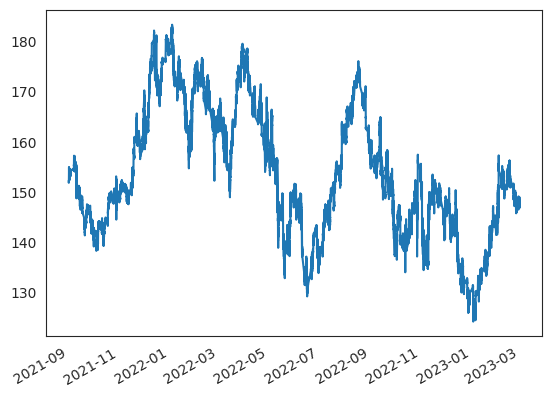

In [3]:
# loading csv with indicators unscaled

hdr = pd.read_csv(params.indunsc_csv, nrows=0).columns.tolist()
index_name = hdr[0]   # first column header, whatever it is

cols_needed = [
    "open","high","low","close","volume","trade_count","vwap","ask","bid",
    params.col_atr_tick, params.col_adx_tick, params.col_rsi_tick, params.col_vwap_tick,
]

usecols = [index_name] + cols_needed

df_inds = pd.read_csv(params.indunsc_csv, usecols=usecols, index_col=index_name, parse_dates=True)
df_inds = df_inds[(df_inds.index >= '2021-09-01') & (df_inds.index < '2023-03-01')] #########################
df_inds.close.plot()
df_inds

In [4]:
##### 1.5e12 ######
# {'min_prof_thr': (0.016690626891460527, 0.01914937310853947),
#  'max_down_prop': (0.005055517512256241, 0.0052844824877437595),
#  'gain_tightfact': (0.06258156924461009, 0.06442843075538993),
#  'tau_time': (9.997165462294742, 10.003114537705258),
#  'tau_dur': (7.497047680299028, 7.555712319700971),
#  'thresh_mode': {'categorical': ['median_nonzero']},
#  'reset_peak': (0, 0),
#  'rsi_min_thresh': (0, 0),
#  'rsi_max_thresh': (66, 70),
#  'adx_thresh': (8.552802178185974, 8.645307821814026),
#  'atr_mult': (0.2997936509253488, 0.31198634907465117),
#  'vwap_atr_mult': (-2.003542773559526, -1.7800672264404735),
#  'buy_factor': (0.004935982052890333, 0.005774017947109668),
#  'sell_factor': (0.01003081719274689, 0.01115918280725311),
#  'trailstop_pct': (15.939942033425433, 17.86065796657457)}

##### 3e11 ######
# {'min_prof_thr': (-0.0025867651709173605, 0.009376765170917359),
#  'max_down_prop': (0.0021117462457834668, 0.0046282537542165336),
#  'gain_tightfact': (0.025934169886688174, 0.04553583011331183),
#  'tau_time': (8.14871959583157, 8.258420404168428),
#  'tau_dur': (5.274328228378261, 6.13339177162174),
#  'thresh_mode': {'categorical': ['median_nonzero']},
#  'reset_peak': (0, 0),
#  'rsi_min_thresh': (0, 2),
#  'rsi_max_thresh': (79, 109),
#  'adx_thresh': (7.443533163797652, 9.061096836202346),
#  'atr_mult': (0.09063916029929553, 0.12457083970070448),
#  'vwap_atr_mult': (-2.899059454044301, 0.7521294540443009),
#  'buy_factor': (-0.004088046746404329, 0.007088046746404328),
#  'sell_factor': (-0.005813917610810894, 0.008653917610810894),
#  'trailstop_pct': (8.858183800998932, 24.185076199001074)}

In [5]:
# prun_perc       = 80
# report_interval = 50

# def objective(trial: optuna.Trial) -> float:
    
#     min_prof_thr    = trial.suggest_float("min_prof_thr", 0.001, 0.01)      
#     max_down_prop   = trial.suggest_float("max_down_prop", 0.002, 0.005)    
#     gain_tightfact  = trial.suggest_float("gain_tightfact", 0.03, 0.06)   
#     tau_time        = trial.suggest_float("tau_time", 8, 9.5)          
#     tau_dur         = trial.suggest_float("tau_dur", 5.5, 7)          
    
#     thresh_mode     = trial.suggest_categorical("thresh_mode",
#                            ["median_nonzero"])
#     thresh_window   = (trial.suggest_int("thresh_window", 10, 100)
#                        if "roll" in thresh_mode else None)
    
#     reset_peak     = trial.suggest_categorical("reset_peak", [False])
#     rsi_min_thresh = trial.suggest_int("rsi_min_thresh", 0, 5)            
#     rsi_max_thresh = trial.suggest_int("rsi_max_thresh", max(rsi_min_thresh + 1, 70), 100)          
#     adx_thresh     = trial.suggest_float("adx_thresh", 7.5, 9)          
#     atr_mult       = trial.suggest_float("atr_mult", 0.1, 0.2)             
#     vwap_atr_mult  = trial.suggest_float("vwap_atr_mult", -3, 1)       
#     buy_factor     = trial.suggest_float("buy_factor", 0.001, 0.01)        
#     sell_factor    = trial.suggest_float("sell_factor", 0.001, 0.01)       
#     trailstop_pct  = trial.suggest_float("trailstop_pct", 5, 25)       

#     print("-" * 160)
#     print("Params => " + "; ".join(f"{k}={v}" for k, v in dict(trial.params).items()))

#     # Build signals for this trial
#     df = preps.build_signal_per_day(
#         df              = df_inds.copy(),
#         min_prof_thr    = min_prof_thr,
#         max_down_prop   = max_down_prop,
#         gain_tightfact  = gain_tightfact,
#         tau_time        = tau_time,
#         tau_dur         = tau_dur,
#         thresh_mode     = thresh_mode,
#         thresh_window   = thresh_window,
#     )

#     # Group per-day for this trial
#     groups_list = list(df.groupby(df.index.normalize()))

#     # Reset globals
#     start_ask = df.loc[df.index.normalize() == df.index.normalize().min(), "ask"].iat[0]
#     strats.reset_globals(start_ask)

#     daily_pnls, daily_bh_pnls = [], []
#     trial_action_counts = {"Buy": 0, "Sell": 0, "Hold": 0}

#     pbar = tqdm(groups_list, desc=f"Trial {trial.number}", leave=True)
#     for step, (day, df_day) in enumerate(pbar, 1):
#         df_actions = strats.generate_actions_alpaca(
#             df              = df_day,
#             col_signal      = "signal_raw",
#             sign_thresh     = "signal_thresh",
#             col_atr         = params.col_atr_tick,
#             col_adx         = params.col_adx_tick,
#             col_rsi         = params.col_rsi_tick,
#             col_vwap        = params.col_vwap_tick,
#             reset_peak      = reset_peak,
#             rsi_min_thresh  = rsi_min_thresh,
#             rsi_max_thresh  = rsi_max_thresh,
#             adx_thresh      = adx_thresh,
#             atr_mult        = atr_mult,
#             vwap_atr_mult   = vwap_atr_mult,
#             trailstop_pct   = trailstop_pct,
#         )

#         sim_results = strats.simulate_trading(
#             day         = day,
#             df          = df_actions,
#             buy_factor  = buy_factor,
#             sell_factor = sell_factor,
#         )

#         df_sim, trades, stats = next(iter(sim_results.values()))

#         trial_action_counts["Buy"]  += int((df_sim["Action"] == "Buy").sum())
#         trial_action_counts["Sell"] += int((df_sim["Action"] == "Sell").sum())
#         trial_action_counts["Hold"] += int((df_sim["Action"] == "Hold").sum())

#         daily_pnls.append(strats._parse_eq_value(stats["STRATEGY"]))
#         daily_bh_pnls.append(strats._parse_eq_value(stats["BUYNHOLD"]))

#         if step % report_interval == 0:
#             report_step = step // report_interval
#             prun_val = float(np.mean(np.array(daily_pnls) - np.array(daily_bh_pnls)))

#             trial.set_user_attr("mean_pnl",      float(np.mean(daily_pnls)))
#             trial.set_user_attr("mean_bh_pnls",  float(np.mean(daily_bh_pnls)))
#             trial.set_user_attr("action_counts", {k: int(v) for k, v in trial_action_counts.items()})

#             trial.report(prun_val, report_step)
#             if trial.should_prune():
#                 vals = [
#                     t.intermediate_values[report_step]
#                     for t in trial.study.get_trials(deepcopy=False)
#                     if t.state == TrialState.COMPLETE and report_step in t.intermediate_values
#                 ]
#                 thr = np.percentile(vals, prun_perc) if vals else prun_val
#                 print(f"[PRUNE] value={prun_val:.6f} thr={thr:.6f}")
#                 pbar.close()
#                 raise optuna.TrialPruned()

#     trial.set_user_attr("mean_pnl",     float(np.mean(daily_pnls)))
#     trial.set_user_attr("mean_bh_pnls", float(np.mean(daily_bh_pnls)))
#     trial.set_user_attr("action_counts",{k: int(v) for k, v in trial_action_counts.items()})

#     mean_excess = float(np.mean(np.array(daily_pnls) - np.array(daily_bh_pnls)))
#     return mean_excess



In [6]:
prun_perc       = 80
report_interval = 50

col_signal = "signal_raw"

def objective(trial: optuna.Trial) -> float:
    min_prof_thr    = trial.suggest_float("min_prof_thr", 0.001, 0.01)
    max_down_prop   = trial.suggest_float("max_down_prop", 0.002, 0.005)
    gain_tightfact  = trial.suggest_float("gain_tightfact", 0.03, 0.06)
    tau_time        = trial.suggest_float("tau_time", 8, 9.5)
    tau_dur         = trial.suggest_float("tau_dur", 5.5, 7)
    
    thresh_choice = trial.suggest_categorical("thresh_choice",
        ["median_nonzero", "mean_nonzero", "p90", "p95", "p99", "median", "mean", "roll_mean", "roll_median", "roll_p90", "roll_p95", "numeric"])

    if thresh_choice == "numeric":
        thresh_mode = trial.suggest_float("thresh_value", 0.01, 1.0)
        thresh_window = None
    else: # signal threshold
        thresh_mode = thresh_choice
        thresh_window = trial.suggest_int("thresh_window", 5, 200) if thresh_choice.startswith("roll") else None

    reset_peak     = trial.suggest_categorical("reset_peak", [False])
    rsi_min_thresh = trial.suggest_int("rsi_min_thresh", 0, 5)
    rsi_max_thresh = trial.suggest_int("rsi_max_thresh", max(rsi_min_thresh + 1, 70), 100)
    adx_thresh     = trial.suggest_float("adx_thresh", 7.5, 9)
    atr_mult       = trial.suggest_float("atr_mult", 0.1, 0.2)
    vwap_atr_mult  = trial.suggest_float("vwap_atr_mult", -3, 1)
    buy_factor     = trial.suggest_float("buy_factor", 0.001, 0.01)
    sell_factor    = trial.suggest_float("sell_factor", 0.001, 0.01)
    trailstop_pct  = trial.suggest_float("trailstop_pct", 5, 25)

    print("-" * 160)
    print("Params => " + "; ".join(f"{k}={v}" for k, v in dict(trial.params).items()))

    # 1) detect swings / build raw signal columns (no thresholding)
    df_detect = preps.build_signal_per_day(
        df              = df_inds.copy(),
        min_prof_thr    = min_prof_thr,
        max_down_prop   = max_down_prop,
        gain_tightfact  = gain_tightfact,
        tau_time        = tau_time,
        tau_dur         = tau_dur,
        col_close       = "close",
    )

    # 2) compute per-day thresholds and gap_to_thresh
    df_thresh = preps.apply_thresholds_per_day(
        df              = df_detect,
        thresh_mode     = thresh_mode,
        thresh_window   = thresh_window,
        col_signal      = col_signal
    )

    # Group per-day for this trial
    groups = list(df_thresh.groupby(df_thresh.index.normalize()))

    # Reset globals
    start_ask = df_thresh.loc[df_thresh.index.normalize() == df_thresh.index.normalize().min(), "ask"].iat[0]
    strats.reset_globals(start_ask)

    daily_pnls, daily_bh_pnls = [], []
    trial_action_counts = {"Buy": 0, "Sell": 0, "Hold": 0}

    pbar = tqdm(groups, desc=f"Trial {trial.number}", leave=True)
    for step, (day, df_day) in enumerate(pbar, 1):
        df_actions = strats.generate_actions_alpaca(
            df              = df_day,
            col_signal      = col_signal,
            sign_thresh     = "signal_thresh",
            col_atr         = params.col_atr_tick,
            col_adx         = params.col_adx_tick,
            col_rsi         = params.col_rsi_tick,
            col_vwap        = params.col_vwap_tick,
            reset_peak      = reset_peak,
            rsi_min_thresh  = rsi_min_thresh,
            rsi_max_thresh  = rsi_max_thresh,
            adx_thresh      = adx_thresh,
            atr_mult        = atr_mult,
            vwap_atr_mult   = vwap_atr_mult,
            trailstop_pct   = trailstop_pct,
        )

        sim_results = strats.simulate_trading(
            day         = day,
            df          = df_actions,
            buy_factor  = buy_factor,
            sell_factor = sell_factor,
        )

        df_sim, trades, stats = next(iter(sim_results.values()))

        trial_action_counts["Buy"]  += int((df_sim["Action"] == "Buy").sum())
        trial_action_counts["Sell"] += int((df_sim["Action"] == "Sell").sum())
        trial_action_counts["Hold"] += int((df_sim["Action"] == "Hold").sum())

        daily_pnls.append(strats._parse_eq_value(stats["STRATEGY"]))
        daily_bh_pnls.append(strats._parse_eq_value(stats["BUYNHOLD"]))

        if step % report_interval == 0:
            report_step = step // report_interval
            prun_val = float(np.mean(np.array(daily_pnls) - np.array(daily_bh_pnls)))

            trial.set_user_attr("mean_pnl",      float(np.mean(daily_pnls)))
            trial.set_user_attr("mean_bh_pnls",  float(np.mean(daily_bh_pnls)))
            trial.set_user_attr("action_counts", {k: int(v) for k, v in trial_action_counts.items()})

            trial.report(prun_val, report_step)
            if trial.should_prune():
                vals = [
                    t.intermediate_values[report_step]
                    for t in trial.study.get_trials(deepcopy=False)
                    if t.state == TrialState.COMPLETE and report_step in t.intermediate_values
                ]
                thr = np.percentile(vals, prun_perc) if vals else prun_val
                print(f"[PRUNE] value={prun_val:.6f} thr={thr:.6f}")
                pbar.close()
                raise optuna.TrialPruned()

    trial.set_user_attr("mean_pnl",     float(np.mean(daily_pnls)))
    trial.set_user_attr("mean_bh_pnls", float(np.mean(daily_bh_pnls)))
    trial.set_user_attr("action_counts",{k: int(v) for k, v in trial_action_counts.items()})

    mean_excess = float(np.mean(np.array(daily_pnls) - np.array(daily_bh_pnls)))
    return mean_excess


Baseline mean daily B&H: -9.5162


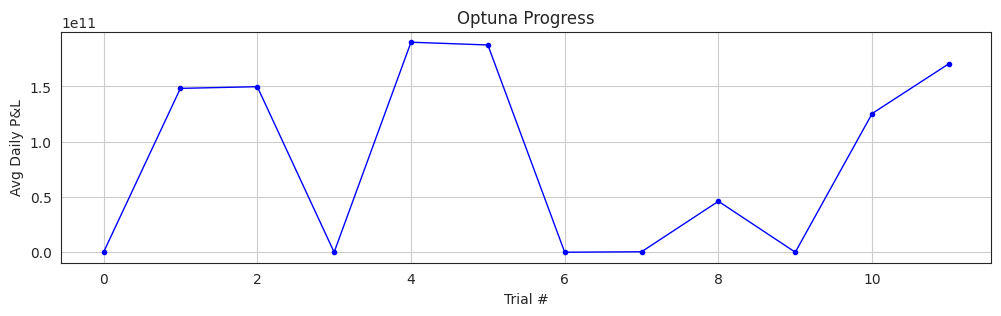

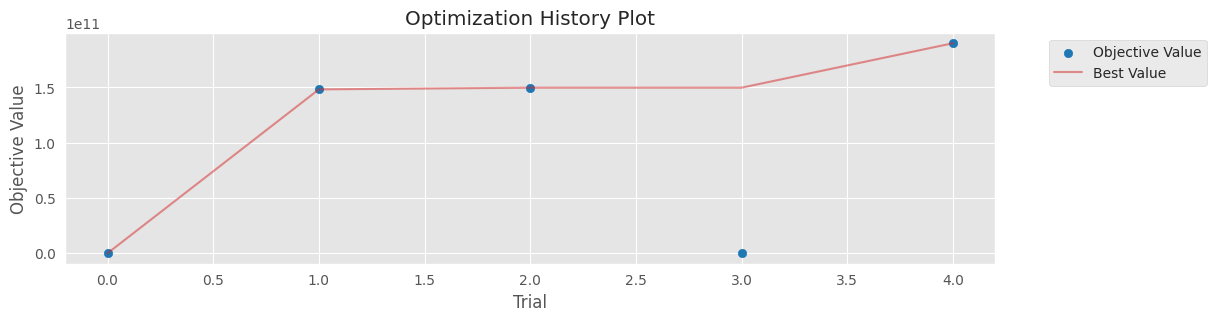

----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.008170284596219053; max_down_prop=0.004938848536936446; gain_tightfact=0.051125021888757574; tau_time=8.906307585056695; tau_dur=5.5394197356940476; thresh_choice=p99; reset_peak=False; rsi_min_thresh=5; rsi_max_thresh=91; adx_thresh=7.556750954265294; atr_mult=0.12506729441318598; vwap_atr_mult=-0.5110256157495994; buy_factor=0.009798825370611643; sell_factor=0.009177240876363159; trailstop_pct=7.558668709628207


Trial 0: 100%|██████████| 375/375 [01:21<00:00,  4.60it/s]


[Results] mean_pnl:1510.3953 mean_bh:-8.7491 mean_excess:1519.1443 improv_vs_bh:17363.45%
Action counts: {'Buy': 1953, 'Sell': 4219, 'Hold': 344539}
Best trial is: 0 with best_val: 1519.1443
[save_results] wrote optuna_results/AAPL_1519.1443_target.csv
[save_best_json] wrote optuna_results/AAPL_1519.1443_target.json
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.00401066534332639; max_down_prop=0.0027889104608801443; gain_tightfact=0.04741361126637858; tau_time=8.398673445658815; tau_dur=6.764091324797355; thresh_choice=mean; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=89; adx_thresh=8.936059813048843; atr_mult=0.1345009242387048; vwap_atr_mult=-1.272826546186622; buy_factor=0.009114012455694251; sell_factor=0.007986813340822997; trailstop_pct=20.473019457758873


Trial 1: 100%|██████████| 375/375 [01:42<00:00,  3.67it/s]


[Results] mean_pnl:148230870957.0339 mean_bh:-8.7491 mean_excess:148230870965.7830 improv_vs_bh:1694243168956.19%
Action counts: {'Buy': 39343, 'Sell': 41297, 'Hold': 270071}
Best trial is: 1 with best_val: 148230870965.7830
[save_results] wrote optuna_results/AAPL_148230870965.783_target.csv
[save_best_json] wrote optuna_results/AAPL_148230870965.783_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.007990090350038958; max_down_prop=0.002489590535613262; gain_tightfact=0.05190898679992855; tau_time=9.300436884501003; tau_dur=5.894262908771289; thresh_choice=median_nonzero; reset_peak=False; rsi_min_thresh=5; rsi_max_thresh=81; adx_thresh=8.827432958146504; atr_mult=0.11613644887823821; vwap_atr_mult=-1.1727001473720926; buy_factor=0.0017182465775582544; sell_factor=0.0035559762104478134; trailstop_pct=20.35106964016349


Trial 2: 100%|██████████| 375/375 [03:05<00:00,  2.02it/s]


[Results] mean_pnl:149776472772.1220 mean_bh:-8.7491 mean_excess:149776472780.8712 improv_vs_bh:1711909025603.17%
Action counts: {'Buy': 42410, 'Sell': 38993, 'Hold': 269308}
Best trial is: 2 with best_val: 149776472780.8712
[save_results] wrote optuna_results/AAPL_149776472780.8712_target.csv
[save_best_json] wrote optuna_results/AAPL_149776472780.8712_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.008083878590070204; max_down_prop=0.0024108115384395452; gain_tightfact=0.04968694511709254; tau_time=9.12101525839434; tau_dur=5.889842762582116; thresh_choice=p95; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=82; adx_thresh=8.878600250980451; atr_mult=0.17813090724040015; vwap_atr_mult=0.9219225311715435; buy_factor=0.004899753960685486; sell_factor=0.007312726746049211; trailstop_pct=14.974786568168097


Trial 3: 100%|██████████| 375/375 [01:51<00:00,  3.36it/s]


[Results] mean_pnl:223763.9086 mean_bh:-8.7491 mean_excess:223772.6577 improv_vs_bh:2557667.61%
Action counts: {'Buy': 8469, 'Sell': 14826, 'Hold': 327416}
Best trial is: 2 with best_val: 149776472780.8712
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0016502931541146192; max_down_prop=0.0032167109661988555; gain_tightfact=0.03804190801703527; tau_time=8.012935800991118; tau_dur=6.3280282716173275; thresh_choice=mean; reset_peak=False; rsi_min_thresh=5; rsi_max_thresh=96; adx_thresh=8.620543121612243; atr_mult=0.13388139290045598; vwap_atr_mult=0.10670867525836547; buy_factor=0.00484417858716539; sell_factor=0.0010078240067641808; trailstop_pct=20.444463770790705


Trial 4: 100%|██████████| 375/375 [01:58<00:00,  3.16it/s]


[Results] mean_pnl:189994714742.4193 mean_bh:-8.7491 mean_excess:189994714751.1684 improv_vs_bh:2171593848890.30%
Action counts: {'Buy': 39490, 'Sell': 41333, 'Hold': 269888}
Best trial is: 4 with best_val: 189994714751.1684
[save_results] wrote optuna_results/AAPL_189994714751.1684_target.csv
[save_best_json] wrote optuna_results/AAPL_189994714751.1684_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0026877247498952248; max_down_prop=0.003087963439663311; gain_tightfact=0.03219877376652573; tau_time=8.360072408490558; tau_dur=5.942805854474266; thresh_choice=median; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=86; adx_thresh=8.895068074225644; atr_mult=0.1526847005606631; vwap_atr_mult=0.675104694620035; buy_factor=0.003115032859796247; sell_factor=0.0026441196070145596; trailstop_pct=15.96900552688945


Trial 5: 100%|██████████| 375/375 [01:59<00:00,  3.13it/s]


[Results] mean_pnl:187502727811.5701 mean_bh:-8.7491 mean_excess:187502727820.3192 improv_vs_bh:2143111038209.83%
Action counts: {'Buy': 42836, 'Sell': 38203, 'Hold': 269672}
Best trial is: 4 with best_val: 189994714751.1684
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.008655191845985268; max_down_prop=0.0037208695846993626; gain_tightfact=0.05831423790554044; tau_time=8.080502706974706; tau_dur=5.738001107179247; thresh_choice=roll_p95; thresh_window=165; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=85; adx_thresh=7.96328466575539; atr_mult=0.12700619998844787; vwap_atr_mult=0.7092837984470046; buy_factor=0.0017067513485480791; sell_factor=0.009065565057307684; trailstop_pct=8.231715132430148


Trial 6: 100%|██████████| 375/375 [01:24<00:00,  4.45it/s]


[Results] mean_pnl:176109.7911 mean_bh:-8.7491 mean_excess:176118.5401 improv_vs_bh:2012992.51%
Action counts: {'Buy': 15733, 'Sell': 22657, 'Hold': 312321}
Best trial is: 4 with best_val: 189994714751.1684
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.006405295319931661; max_down_prop=0.003791366372498799; gain_tightfact=0.05922403098127533; tau_time=8.263562009193034; tau_dur=6.334177547093731; thresh_choice=numeric; thresh_value=0.43593460092809294; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=79; adx_thresh=8.244338340451229; atr_mult=0.17631335063580342; vwap_atr_mult=0.8630164934490772; buy_factor=0.004948950799896014; sell_factor=0.009239070079378228; trailstop_pct=12.10009555805117


Trial 7: 100%|██████████| 375/375 [01:33<00:00,  4.01it/s]


[Results] mean_pnl:414266160.5056 mean_bh:-8.7491 mean_excess:414266169.2547 improv_vs_bh:4734962581.12%
Action counts: {'Buy': 20503, 'Sell': 29250, 'Hold': 300958}
Best trial is: 4 with best_val: 189994714751.1684
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0064161151708333605; max_down_prop=0.003801556827419161; gain_tightfact=0.05859938629583437; tau_time=9.115573145124326; tau_dur=6.091920359846875; thresh_choice=roll_median; thresh_window=129; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=83; adx_thresh=7.663780022251275; atr_mult=0.1106784795206204; vwap_atr_mult=-2.8504637308290133; buy_factor=0.0073192557458235065; sell_factor=0.009751609171419928; trailstop_pct=7.299755892027131


Trial 8: 100%|██████████| 375/375 [01:48<00:00,  3.45it/s]


[Results] mean_pnl:46098937547.3740 mean_bh:-8.7491 mean_excess:46098937556.1231 improv_vs_bh:526899758071.50%
Action counts: {'Buy': 49056, 'Sell': 41554, 'Hold': 260101}
Best trial is: 4 with best_val: 189994714751.1684
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.008203422870429695; max_down_prop=0.0028205138607925026; gain_tightfact=0.04124714415199412; tau_time=8.170483397175195; tau_dur=6.847118307308139; thresh_choice=roll_p90; thresh_window=152; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=99; adx_thresh=8.946241443108251; atr_mult=0.11832889677722463; vwap_atr_mult=-2.2388351090131975; buy_factor=0.009980333769403375; sell_factor=0.008574352330713929; trailstop_pct=22.914003963026005


Trial 9: 100%|██████████| 375/375 [04:04<00:00,  1.53it/s]


[Results] mean_pnl:4251847.3156 mean_bh:-8.7491 mean_excess:4251856.0647 improv_vs_bh:48597691.20%
Action counts: {'Buy': 23523, 'Sell': 32121, 'Hold': 295067}
Best trial is: 4 with best_val: 189994714751.1684
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0010227175338533073; max_down_prop=0.004430463441989038; gain_tightfact=0.03544694089441144; tau_time=8.63660736630976; tau_dur=6.463215964526896; thresh_choice=mean; reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=70; adx_thresh=8.516208294981746; atr_mult=0.15407380208288884; vwap_atr_mult=-0.422860089181889; buy_factor=0.0068555564398151934; sell_factor=0.0013989721956433514; trailstop_pct=24.030975312984467


Trial 10: 100%|██████████| 375/375 [03:56<00:00,  1.58it/s]


[Results] mean_pnl:125480648175.1752 mean_bh:-8.7491 mean_excess:125480648183.9243 improv_vs_bh:1434213599614.37%
Action counts: {'Buy': 38728, 'Sell': 41076, 'Hold': 270907}
Best trial is: 4 with best_val: 189994714751.1684
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0017413746210993833; max_down_prop=0.003166678819217267; gain_tightfact=0.030482412927839275; tau_time=8.467290963572985; tau_dur=6.5338965284123685; thresh_choice=median; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=100; adx_thresh=8.572568936163204; atr_mult=0.15197629303252794; vwap_atr_mult=0.07708420282506614; buy_factor=0.0035684348978363934; sell_factor=0.001059531606958257; trailstop_pct=17.773495325589067


Trial 11: 100%|██████████| 375/375 [04:28<00:00,  1.40it/s]


[Results] mean_pnl:170602701284.3575 mean_bh:-8.7491 mean_excess:170602701293.1065 improv_vs_bh:1949947803639.63%
Action counts: {'Buy': 42758, 'Sell': 38158, 'Hold': 269795}
Best trial is: 4 with best_val: 189994714751.1684
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0033906770305797175; max_down_prop=0.003273956225087321; gain_tightfact=0.03916162520791001; tau_time=8.047276512838748; tau_dur=6.14210308499454; thresh_choice=median; reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=94; adx_thresh=8.560820007205496; atr_mult=0.14217682430410913; vwap_atr_mult=0.18350640874572402; buy_factor=0.00338483681602703; sell_factor=0.0032225261899188227; trailstop_pct=15.085648858273782


Trial 12:  43%|████▎     | 163/375 [01:05<01:53,  1.87it/s]

In [ ]:
importlib.reload(opts) ########
# Warmup steps computed once from base data
base_groups        = list(df_inds.groupby(df_inds.index.normalize()))
total_days_base    = len(base_groups)
reports_per_trial  = math.ceil(total_days_base / report_interval)
n_warmup_steps     = math.ceil(reports_per_trial * 0.30)

start = df_inds.loc[df_inds.index.normalize() == df_inds.index.normalize().min(), "ask"].iat[0]
end   = df_inds.loc[df_inds.index.normalize() == df_inds.index.normalize().max(), "bid"].iat[-1]
baseline_pnl = int(params.init_cash // start) * (end - start) / df_inds.index.normalize().nunique()
print(f"Baseline mean daily B&H: {baseline_pnl:.4f}")

# Create the two display slots just below the baseline output
opts.init_optuna_displays()

optuna.logging.set_verbosity(optuna.logging.ERROR)

n_trials = 5000
trials_before_pruning = 150
trials_of_exploration = 250

# sampler = TPESampler(n_startup_trials=trials_of_exploration, multivariate=True) # , seed=42

pruner = optuna.pruners.PercentilePruner(
    percentile=prun_perc,
    n_startup_trials=trials_before_pruning,
    n_warmup_steps=n_warmup_steps,
)

study = optuna.create_study(pruner=pruner, 
                            # sampler=sampler,
                            direction="maximize")

# Per-run callbacks with suffix "target"
cb_save_csv  = opts.make_save_results_callback("target")
cb_save_json = opts.make_save_best_json_callback("target")

study.optimize(
    objective,
    n_trials=n_trials,
    callbacks=[opts.plot_callback, opts.short_log_callback, cb_save_csv, cb_save_json],
    gc_after_trial=True,
)

plt.close("all"); gc.collect()